# Ramsey King
# DSC 550 - Data Mining
# October 24, 2021
# Term Project Milestone 3

### My term project will consist of being able to guess the main topic of sermons given by members of The Church of Jesus Christ of Latter Day Saints as defined by the designated topic assigned to it at speeches.byu.edu.  The ability to search for sermons by topic on this website is available.  While this specific case is not a business use case of data mining, there are many business use cases for being able to identify text by topic or keyword (i.e. www.google.com).  
### For purposes of this assignment, being able to quickly find topic related sermons is beneficial to members of the Church of Jesus Christ.  On occasion, members of the church are asked to give a sermon of their own on various topics, and having the ability to go to a resource and search the assigned topic by keyword helps to generate discussion points and give guidance as to what is appropriate to discuss.  For this project, we will limit the topics as defined by speeches.byu.edu. to give us an initial dataset of 800 rows before processing.  The topics and the count of the number of sermons given (as of October 4th, 2021) are: Life (108), Jesus Christ (106), Faith (100), Learning (97), Service (73), Discipleship (67), Righteousness (67), Divine Potential (66), Love (66), Adversity (57), Trials (56), Revelation (55), and Missionary Work (53).  This should provide enough data to work with but if there is a need, additional topics will be included to help with the corpus.  

In [24]:
# Retreive talks from topics page using beautifulsoup

from bs4 import BeautifulSoup as bs
import requests
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [25]:
# Get list of urls for each of the topics

url = "https://speeches.byu.edu/topics/"

url_list = [
    'life/', 'jesus-christ/', 'faith/', 'learning/', 'service/', 'discipleship/', 'righteousness/', 
    'divine-potential/', 'love/', 'adversity/', 'trials/', 'revelation/', 'missionary-work/'
]

links = []
new_links = []
# some of the links are repeated with '?M=V' and '?M=A' and those will be removed so we can have a unique set of links to pull talk information from.
for u in url_list:

    response = requests.get(url+u)
    html = response.content
    video = '?M=V'
    soup = bs(html, "lxml")
    for link in soup.findAll("a", attrs={'href': re.compile("^https://speeches.byu.edu/talks/[\D+]")}):
        links.append(link.get('href').replace(video, ''))

    audio = '?M=A'
    for link in links:
        new_link = link.replace(audio, '')
        new_links.append(new_link)
    new_links = list(set(new_links))



In [26]:
'''Retrieves talk text from each of the urls using beautiful soup.  Information such as the talk/sermon text, title, topic, date, and speaker will be retreived
and put into a dataframe.  A csv file will also be saved due to the time it takes to run or in case we need to work offline.'''
talk_text = []
title_text = []
topics = []
dates = []
speakers = []
speaker_position = []

for link in new_links:
    url = link
    response = requests.get(url)
    html = response.content
    soup = bs(html, 'lxml')
    temp_list = []

    link_splitter = link.split('/')
    speakers.append(link_splitter[4].replace('-', ' '))

    result = soup.find('p', class_='single-speech__speaker-subtext single-speech__speaker-position')
    speaker_position.append(result.text if result else 'Title Not Found')

    for div in soup.find_all('div', class_='single-speech__content'):
        talk_text.append(div.get_text(strip=True))
    for h1 in soup.find_all('h1', class_='single-speech__title'):
        title_text.append(h1.get_text(strip=True))        
    for p in soup.find_all('p', class_='single-speech__speaker-subtext single-speech__date'):
        dates.append(p.get_text(strip=True))
    for p in soup.find_all('p', class_='single-speech__related-tag'):
        temp_list.append(p.get_text(strip=True))
        temp_str = ','.join(temp_list)
    topics.append(temp_str)


dict = {'titles': title_text , 'speaker': speakers, 'speaker_position': speaker_position , 'date': dates, 'talks': talk_text, 'topics': topics, }
df = pd.DataFrame(dict)
df.to_csv('talks.csv')

In [27]:
# get word count of each talk
df['word_count'] = df['talks'].apply(lambda x: len(re.findall(r'\w+', x)))

In [28]:
# reduce the topic to the ones selected from our original selection ('life', 'jesus-christ', 'faith', 'learning', 'service')
from datetime import datetime
# the single_topic function takes the list of topics in the 'topics' column and will return the first topic it finds in the 'topic_selection_list'
def single_topic(dataframe_topics):
    column = [word for word in dataframe_topics.split(',')]
    the_string =  ', '.join([val for ind, val in enumerate(topic_selection_list) if val in column])
    return the_string.split(',')[0]

# removes the '/' from the url list and '-' from topics containing dashes such as 'jesus-christ'
topic_selection_list = [x[:-1].replace('-', ' ') for x in url_list]
df['topics'] = df['topics'].apply(lambda x: x.lower())
df['topic_singular'] = df['topics'].apply(single_topic)

# remove quotations ("") and all other punctuation from titles
df['titles'] = df['titles'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# create separate month and year column and create a number column representing the month 
df['month'] = df['date'].apply(lambda x: x.split(' ')[0])
# df['month_dt'] = df['month'].apply(lambda x: datetime.strptime(x, '%B'))
df['month_dt'] = pd.to_datetime(df['month'], format='%B')
df['year'] = df['date'].apply(lambda x: x.split(' ')[2]).astype(int)

def month_to_int(month_string):
    month_dictionary = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12
    }

    return month_dictionary.get(month_string)
    
df['month_number'] = df['month'].apply(month_to_int)

# get the dimensions of the dataset
df.shape


(809, 12)

In [29]:
# Remove the talks that do not contain any data.
print(df.shape)
df = df[df['talks'].str.contains('for this speech is unavailable')==False]
df.shape

(809, 12)


(654, 12)

In [30]:
# Take a peek at the data
df.reset_index(inplace = True, drop = True)
df.head(7)

,titles,speaker,speaker_position,date,talks,topics,word_count,topic_singular,month,month_dt,year,month_number
0,More Than Knowledge,shuei chen valerie woo,Student Representative,"April 21, 2005",When I first found out that I was to speak at ...,"byu,life",755,life,April,1900-04-01,2005,4
1,Believing Christ A Practical Approach to the A...,stephen e robinson,Professor of Ancient Scripture,"May 29, 1990","The greatest dichotomy, the greatest problem i...","atonement,jesus christ,collection: jesus chris...",4641,jesus christ,May,1900-05-01,1990,5
2,It Still Takes Faith,brent l top,Associate Dean of Religious Education,"July 22, 1997","My brothers and sisters, I am honored to have ...","covenants,discipleship,faith,pioneers",7305,faith,July,1900-07-01,1997,7
3,Scholarship and Faith,ross spencer,Title Not Found,"March 30, 2010","It is a privilege to be here today, but I have...","education,gospel,learning",3743,learning,March,1900-03-01,2010,3
4,Our LifeChanging Partnership with the Spirit,michael a jensen,Title Not Found,"May 5, 2009","Brothers and sisters, despite my anxiety over ...","holy ghost,revelation,spirit",4382,revelation,May,1900-05-01,2009,5
5,Investing for Eternity,john h groberg,of the Seventy,"June 15, 1982","My dear brothers and sisters, BYU means a lot ...","kindness,righteousness,service,time management",5879,service,June,1900-06-01,1982,6
6,A Disposition to Do Good Continually,spencer j condie,of the Seventy,"February 9, 2010","As a little boy, a favorite activity in my gra...","repentance,righteousness,worthiness",4238,righteousness,February,1900-02-01,2010,2


In [31]:
# We want to get some inital statistical information from the dataset.
print("Describe Data")
print(df.describe())
print("Summarized Data")
print(df.describe(include=['O']))

Describe Data
         word_count         year  month_number
count    654.000000   654.000000    654.000000
mean    4068.099388  2000.870031      6.186544
std     1501.670848    13.989164      3.265027
min       13.000000  1950.000000      1.000000
25%     3369.500000  1990.000000      3.000000
50%     4133.500000  2004.000000      6.000000
75%     4974.500000  2012.000000      9.000000
max    10827.000000  2021.000000     12.000000
Summarized Data
                   titles          speaker speaker_position            date  \
count                 654              654              654             654   
unique                648              398              187             600   
top     Go Forth to Serve  kevin j worthen  Title Not Found  April 30, 2004   
freq                    4               16              187               5   

                                                    talks topics  \
count                                                 654    654   
unique         

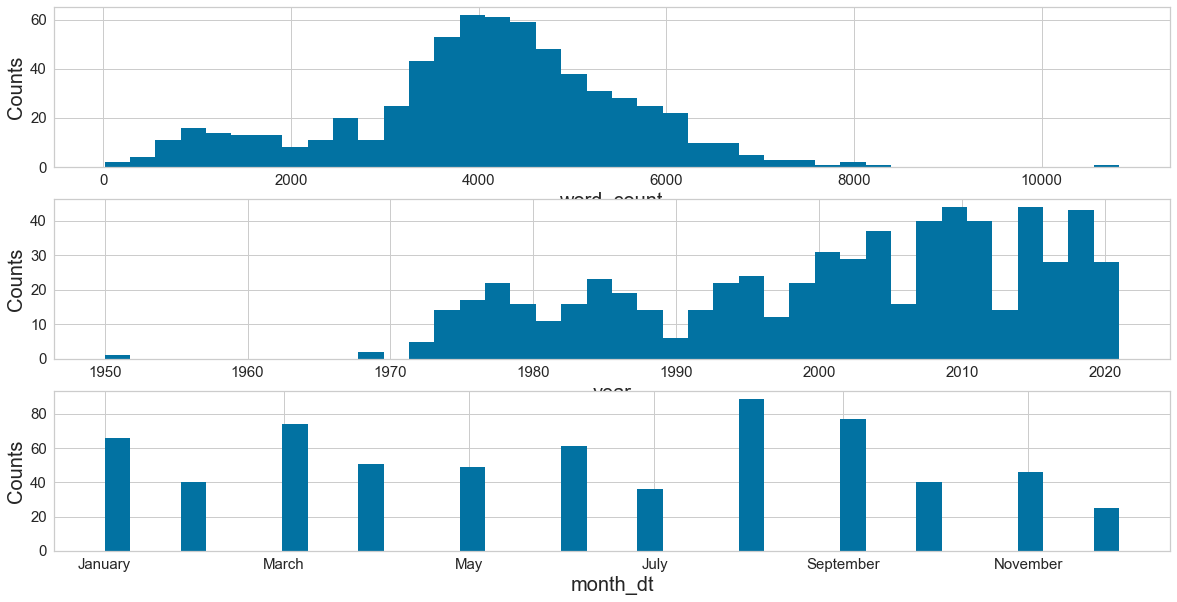

In [32]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 3, ncols = 1)

# Specify the features of interest
num_features = ['word_count', 'year', 'month_dt']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    if idx == 2:
        date_form = DateFormatter('%B')
        ax.xaxis.set_major_formatter(date_form)
        ax.hist(df[num_features[idx]].dropna(), bins=40)
        ax.set_xlabel(xaxes[idx], fontsize=20)
        ax.set_ylabel(yaxes[idx], fontsize=20)
        ax.tick_params(axis='both', labelsize=15)    
    else:
        ax.hist(df[num_features[idx]].dropna(), bins=40)
        ax.set_xlabel(xaxes[idx], fontsize=20)
        ax.set_ylabel(yaxes[idx], fontsize=20)
        ax.tick_params(axis='both', labelsize=15)

plt.show()

Based on the plot above, we can make a few observations:  
- The overall number of talks increased as time has gone on.
- August seems to be a popular month for people to give talks at Brigham Young University (suggesting that it coincides with the beginning of the school year)

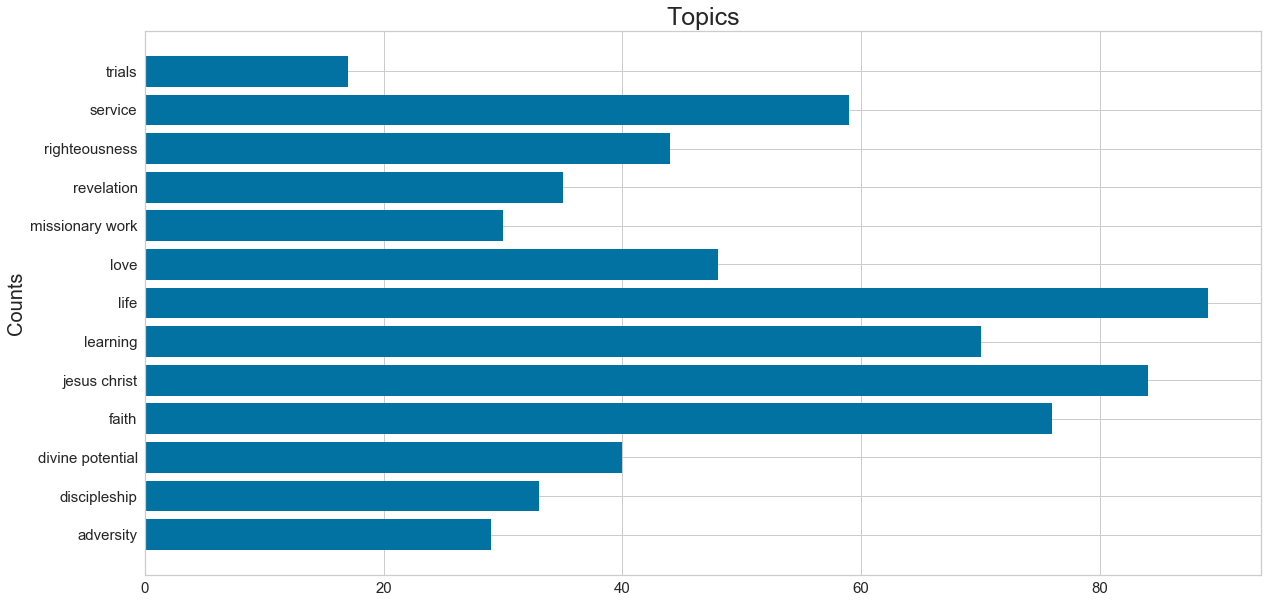

In [33]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visulizer
X_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['topic_singular']
Y_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['Counts']
# make the bar plot
axes.barh(X_Topics, Y_Topics)
axes.set_title('Topics', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)

plt.show()


Observations from the topics bar chart:
- Jesus Christ and Life are the most popular topics (of the most popular topics).  
- All of the most popular seem to fall in line with a private religious university

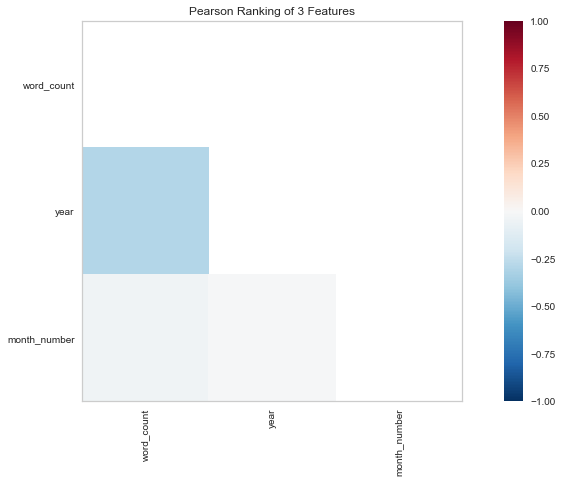

In [34]:
#set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

num_features = ['word_count', 'year', 'month_number']

# extract the numpy arrays from the data frame
X = df[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="pcoords1.png") # Draw/show/poof the data
plt.show()

A few observations from the Pearson Ranking matrix plot:
- As the years increase (become more recent to our day), the speakers seem to have more to say (use more words).
- The later in the year, the less sermons are given.  Maybe this is due to July being a summer month with not a lot of the student body present on campus, and December has winter break.

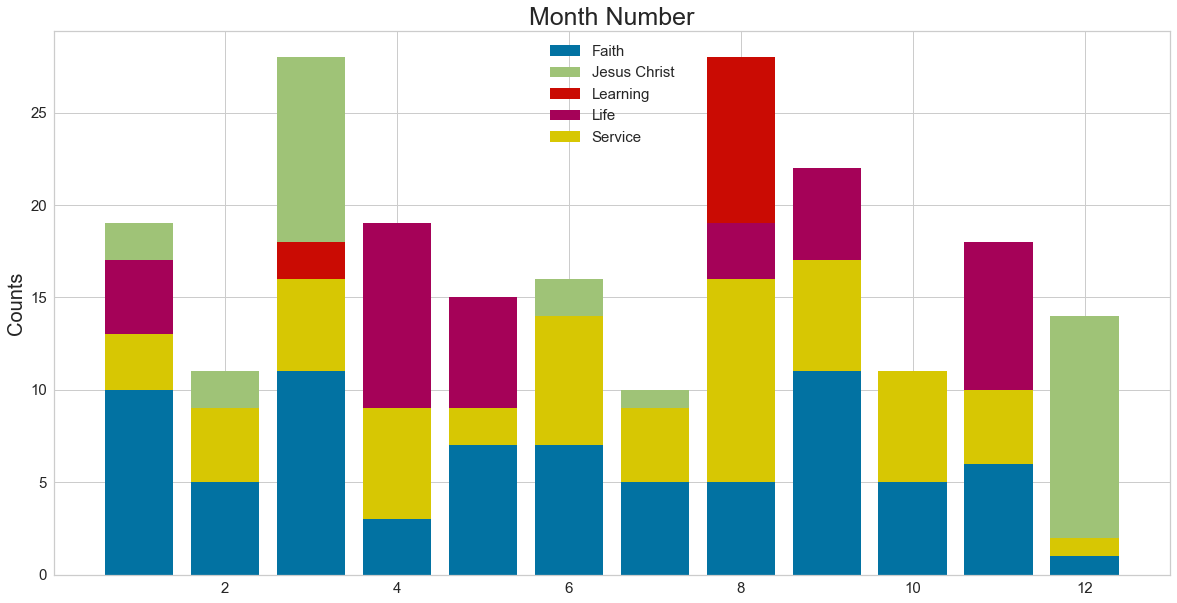

In [35]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visulizer
month_number_faith = df[df['topic_singular']=='faith']['month_number'].value_counts()

month_number_jc = df[df['topic_singular']=='jesus christ']['month_number'].value_counts()
month_number_jc = month_number_jc.reindex(index = month_number_faith.index)

month_number_learning = df[df['topic_singular']=='learning']['month_number'].value_counts()
month_number_learning = month_number_learning.reindex(index = month_number_faith.index)

month_number_life = df[df['topic_singular']=='life']['month_number'].value_counts()
month_number_life = month_number_life.reindex(index = month_number_faith.index)

month_number_service = df[df['topic_singular']=='service']['month_number'].value_counts()
month_number_service = month_number_service.reindex(index = month_number_faith.index)
# make the bar plot
p1 = axes.bar(month_number_faith.index, month_number_faith.values)
p2 = axes.bar(month_number_jc.index, month_number_jc.values, bottom=month_number_faith.values)
p3 = axes.bar(month_number_learning.index, month_number_learning.values, bottom=month_number_faith.values)
p4 = axes.bar(month_number_life.index, month_number_life.values, bottom=month_number_faith.values)
p5 = axes.bar(month_number_service.index, month_number_service.values, bottom=month_number_faith.values)
# date_form = DateFormatter('%B')
# axes.xaxis.set_major_formatter(date_form)
axes.set_title('Month Number', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)
axes.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Faith', 'Jesus Christ', 'Learning', 'Life', 'Service'), fontsize = 15)

plt.show()


The following observations can be made from the chart above:

- August is the most popular month for talks, with an overwhelming majority of the learning topics being contained there.
- December is a popular month to discuss Jesus Christ (more than likely due to Christmas).
- Faith and Service is a common theme no matter the time of year.
- Jesus Christ as a topic is popular in March (perhaps due to Easter?).

It will be interesting as we continue on with this project how these variables will play into the predictability of the project.

In Milestone 2, you should drop any features that are not useful for your model building. You should explain and justify why the feature dropped is not useful. You should address any missing data issues. Build any new features that you need for your model, e.g., create dummy variables for categorical features if necessary. Explain your process at each step. You can use any methods/tools you think are most appropriate. Again, keep in mind that this may look very different from what is done in the Titanic tutorial case study. You should do what makes sense for your project. Be careful to avoid data snooping in these steps.

There are some talks that were srcaped that do not contain any text.  These talks need to be eliminated from the data set before moving forward as they do not provide any useful information.

Build any new features that you need for your model, e.g., create dummy variables for categorical features if necessary.

We will now create dummy variables for the categorical designations in the topic_singular column that will be later used for model analysis.  Instead of using a dictionary to assign values to the categories (i.e. adversity = 1, divine potential = 2, etc.), we will use the get_dummies section so that the model will not give more importance to a higher number.

In [36]:
# Assign the singular topics an number ID for model analysis

df = pd.get_dummies(df, prefix='topic_singular', columns=['topic_singular'])
df.head(7)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   titles                           654 non-null    object        
 1   speaker                          654 non-null    object        
 2   speaker_position                 654 non-null    object        
 3   date                             654 non-null    object        
 4   talks                            654 non-null    object        
 5   topics                           654 non-null    object        
 6   word_count                       654 non-null    int64         
 7   month                            654 non-null    object        
 8   month_dt                         654 non-null    datetime64[ns]
 9   year                             654 non-null    int32         
 10  month_number                     654 non-null    int64        

In Milestone 3, you will begin the process of model selection and evaluation. In addition, write step-by-step instructions for performing the model evaluation and selection part of your case study.

In Milestone 3, you should build and evaluate at least one model. You can use any methods/tools you think are most appropriate, but you should explain/justify why you are choosing the model(s) and evaluation metric(s) you choose. It is important to think about what type of model and metric makes sense for the context of your problem. If you are familiar with hyperparameter tuning, this would also be a great addition to your project.

Write a short overview/conclusion of the insights gained from your model building/evaluation.

After reading Chapter 5 of Applied Text Analysis with Python, I realize that I need to do some more pre-processing before building a model.

In [38]:
df['talks'][1]

'The greatest dichotomy, the greatest problem in the entire universe, consists of two facts. The first we can read in Doctrine and Covenants 1:31: “For I the Lord cannot look upon sin with the least degree of allowance.” That means he can’t stand it, he can’t tolerate it, he can’t blink, or look the other way, or sweep it under the rug. He can’t tolerate sin in the least degree. The other side of the dichotomy is very simply put: I sin, and so do you. If that were all there were to the equation, the conclusion would be inescapable that we, as sinful beings, cannot be tolerated in the presence of God.But that is not all there is to the equation. This morning I would like to talk to you about the Atonement of Christ, that glorious plan by which this dichotomy can be resolved. I would like to share with you incidents from my own life that illustrate how the Atonement works in a practical, everyday setting.Believing ChristFirst is a story about my son, Michael, who did something wrong when